In [2]:
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
import graphviz
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 모델 성능 평가
- 평가일 : 03.13
- 성명 : 김기현
- 점수 : 90

In [4]:
def get_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'weighted')
    recall = recall_score(y_test, pred, average = 'binary')
    f1 = f1_score(y_test, pred, average = 'binary')
    auc = roc_auc_score(y_test, pred_proba, multi_class = 'ovr')
    print(f'오차행렬 : \n{confusion} \n\n정확도 : {accuracy:.3f} \n정밀도 : {precision:.3f} \n재현율 : {recall:.3f} \nf1 : {f1:.3f} \nauc : {auc:.3f}')

Q1. iris data를 불러와서 붓꽃의 종류를 분류하는 모델링을 수행한 후 오차행렬과 정확도를 평가하세요.
- test_size = 0.2, 분류기는 DecisionTreeClassifier를 이용

정답

In [335]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

dt_clf = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
pred_proba = dt_clf.predict_proba(X_test)

confusion = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average = 'macro')


print(confusion)
print('정확도', accuracy)
precision

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
정확도 0.9666666666666667


0.9696969696969697

Q2. 타이타닉 분석용 데이터세트인 tdf1.pkl를 불러와서 생존자 예측 모델을 만든 후 오차행렬, 정확도, 재현율, f1, AUC를 포함하는 사용자 함수를 활용하여 평가하세요.
- test_size = 0.2, 분류기는 RandomForestClassifier 이용

정답

In [5]:
tdf = pd.read_pickle('./data/tdf1.pkl')

X = tdf.iloc[:, 1:]
y = tdf.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
pred_proba = rf_clf.predict_proba(X_test)[:, 1]

get_eval(y_test, pred, pred_proba)

오차행렬 : 
[[88 22]
 [24 45]] 

정확도 : 0.743 
정밀도 : 0.742 
재현율 : 0.652 
f1 : 0.662 
auc : 0.780


Q3. Q2에서 생성한 모델로 교차검증(cv=5)을 수행하고 평균 정확도를 출력하세요.

정답

In [6]:
score = cross_val_score(rf_clf, X, y, cv = 5, scoring = 'accuracy')
print('평균 정확도 :', round(np.mean(score), 3))

평균 정확도 : 0.794


Q4. Q2에서 생성한 예측모델에 대하여 교차 검증 및 성능 개선을 수행하세요.(GridSearchCV 활용)

정답

In [44]:
params = {'n_estimators': [50, 100],
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': [1, 2, 3]}

grid = GridSearchCV(rf_clf, param_grid = params, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)
estimator = grid.best_estimator_
pred = estimator.predict(X_test)
pred_proba = estimator.predict_proba(X_test)[:, 1]

print('최적 파라미터', grid.best_params_)
get_eval(y_test, pred, pred_proba)

최적 파라미터 {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
오차행렬 : 
[[97 13]
 [22 47]] 

정확도 : 0.804 
정밀도 : 0.783 
재현율 : 0.681 
f1 : 0.729 
auc : 0.822


Q5 ~ Q7. 'dataset/diabetes.csv'을 불러와서 아래사항을 수행하세요.
- 피마 인디언 당뇨병 예측을 로지스틱 회귀를 이용하여 수행하고 사용자 함수를 작성하여 평가(오차행렬, 정확도, 정밀도, 재현율, F1, ROC_AUC)
- 임곗값을 0.3에서 0.5까지 변화시키면서 정밀도와 재현율이 조정되는 과정을 시각화 
- 재현율 기준의 성능을 개선하기 위하여 그 값이 0이 될 수 없는 각 칼럼을 탐색하여 적절한 처리를 한 후 로지스틱 회귀로 예측 및 평가 수행(오차행렬, 정확도, 정밀도, 재현율, F1, ROC_AUC)


정답
정답
오답

In [216]:
diabet = pd.read_csv('./data/diabetes.csv')
display(diabet.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [349]:
X = diabet.iloc[:, :-1]
y = diabet.iloc[:, -1]

lr_clf = LogisticRegression(random_state = 0, n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_eval(y_test, pred, pred_proba)

오차행렬 : 
[[90 10]
 [21 33]] 

정확도 : 0.799 
정밀도 : 0.796 
재현율 : 0.611 
f1 : 0.680 
auc : 0.879


In [ ]:
오차행렬 : 
[[90 10]
 [21 33]] 

정확도 : 0.799 
정밀도 : 0.767 
재현율 : 0.611 
f1 : 0.680 
auc : 0.879

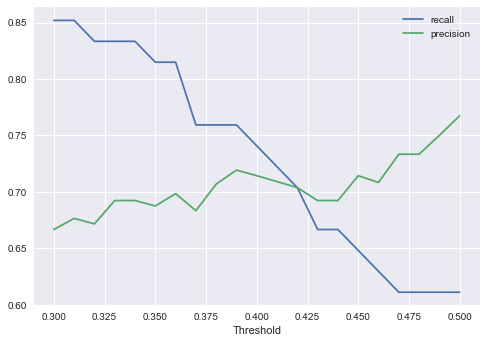

In [218]:
threshold = np.arange(0.3, 0.51, 0.01)

recalls = []
precisions = []
for i in threshold:
    pred_re = Binarizer(threshold = i).fit_transform(pred_proba.reshape(1, -1))
    recall = recall_score(y_test, pred_re.reshape(-1))
    precision = precision_score(y_test, pred_re.reshape(-1))
    recalls.append(recall)
    precisions.append(precision)
    
plt.plot(threshold, recalls, label = 'recall')
plt.plot(threshold, precisions, label = 'precision')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [229]:
for i in diabet.columns:
    a = diabet.loc[diabet[i] == 0].index
    print(i)
    print(len(list(a)))

Pregnancies
111
Glucose
5
BloodPressure
35
SkinThickness
227
Insulin
374
BMI
11
DiabetesPedigreeFunction
0
Age
0
Outcome
500


Q8. "dataset/auto-mpg1.xlsx"을 불러와서 회귀 모델을 생성하고 MSE, RMSE, R2로 평가를 수행하세요.

정답

In [9]:
autodf = pd.read_excel('./data/auto-mpg1.xlsx')
autodf.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [17]:
autodf['horsepower'].unique()
autodf_re = autodf.drop(autodf.loc[autodf['horsepower'] == '?'].index, axis = 0)
autodf_re = autodf_re.drop(['car name', 'model year', 'origin'], axis = 1)
autodf_re['horsepower'] = autodf_re['horsepower'].astype(int)
X = autodf_re.iloc[:, 1:]
y = autodf_re.iloc[:, 0]

lr_reg = LinearRegression(n_jobs = -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print(f'mse: {mse:.3f}, rmse : {round(rmse, 3)}, r2 : {round(r2, 3)}')

mse: 19.004, rmse : 4.359, r2 : 0.694


Q9. 'load_boston' 을 불러와서 cross_val_score를 이용한 cv=5인 교차검증을 수행 후 MSE, RMSE를 출력하세요.(LineaRegression) 

정답

In [214]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

X = boston_df[['LSTAT', 'PTRATIO', 'TAX', 'CRIM', 'RAD', 'AGE', 'ZN', 'RM']]
y = boston_target

lr_reg = LinearRegression(n_jobs = -1)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)

score = cross_val_score(lr_reg, np.log1p(X), y, scoring = 'neg_mean_squared_error', cv = kfold)
mse = np.round(-1 * score, 3)
rmse = np.sqrt(mse)
print('개별 mse :', mse)
print('개별 rmse :', np.round(rmse, 3))
print('평균 mse :', round(np.mean(mse), 3))
print('평균 mse :', round(np.mean(rmse), 3))

개별 mse : [36.028 17.962 19.279 21.388 20.726]
개별 rmse : [6.002 4.238 4.391 4.625 4.553]
평균 mse : 23.077
평균 mse : 4.762


Q10. 'Q9에 대하여 R2 Score를 구하세요.(k=5) 

정답

In [213]:
r2score = cross_val_score(lr_reg, np.log1p(X), y, scoring = 'r2', cv = kfold)
print('개별 r2 : ', np.round(r2score, 3))
print('평균 r2 : ', round(np.mean(r2score), 3))

개별 r2 :  [0.558 0.786 0.698 0.757 0.799]
평균 r2 :  0.72
